# Lifetime of GTOs and Highly Elliptical Orbits

## Summary of Findings

* The Sun and Moon perturbations can have large effects on the orbital lifetime, particularly the orbit orientation with respect to the moon.

* Due to the highly sensative nature of highly elliptical orbits the orbital lifetime variability is rather large, due to drag, and solar/lunar perturbations.

* The Lifetime Tool offers a good initial guess for GTOs but running HPOP shows a wider variability in outcomes.


In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
import os
import pickle
import time
from functools import reduce
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
from IPython.display import Image
from LifeTimeLib import *

%config Completer.use_jedi = False

# What are orbit lifetimes and the key influencing factors for GTOs?

###  Look at the data set

GTO like trajectories with different Cd * Drag Area / Mass ratios

In [2]:
# Load trade study file
tradeStudy = loadTradeStudy("LifeTimeResultsGTOs")
tradeStudy.properties()

{'fileName': 'LifeTimeResultsGTOs.csv',
 'numCores': 4,
 'runHPOP': False,
 'maxDur': 200,
 'decayAlt': 65,
 'epoch': 19253.16666667,
 'a': 6778,
 'e': 0,
 'i': 45,
 'AoP': 0,
 'RAAN': 0,
 'TA': 0,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 13.65,
 'SunArea': 15.43,
 'Mass': 1000,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 10,
 'GaussQuad': 2,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'GridSearch',
 'numberOfRuns': 139968,
 'varyCols': ['epoch',
  'Rp',
  'Ra',
  'i',
  'AoP',
  'RAAN',
  'Cd',
  'Cr',
  'Drag Area',
  'Mass',
  'Flux Sigma Level'],
 'varyValues': [array([19253.16666667, 19360.        ]),
  array([6578, 6678, 6778]),
  array([42164]),
  array([ 0, 15, 30]),
  array([  0, 180]),
  array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
         202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5]),
  array([1.5, 2. , 2.5]),
  array([0.5, 1. , 1.5]),
  array([ 1, 20, 50]),
  array([  10,  500, 2000]),
  array([-2,  0

In [3]:
# Load Data Frame
dfRes = readResults(tradeStudy)
dfRes = dfRes.loc[
    (dfRes["Cd*Drag Area/Mass"] > 0.001) & (dfRes["Cd*Drag Area/Mass"] < 1)
]

# Summary statistics
dfRes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime
count,98496.000000,98496.000000,98496.000000,98496.000000,98496.000000,98496.000000,98496.000000,98496.0,98496.000000,98496.0,98496.000000,9.849600e+04,9.849600e+04,98496.0,9.849600e+04,9.849600e+04,9.849600e+04,98496.000000,98496.00000,98496.000000,98496.000000,98496.000000,98496.000000,98496.000000,98496.0,98496.0,98496.000000,98496.000000,98496.000000,98496.000000
mean,73015.078947,19306.583333,24421.000000,0.726552,15.000000,191.250000,270.000000,360.0,6678.000000,42164.0,11529.676250,-3.693529e-17,-1.385074e-16,0.0,-2.795396e-19,2.885570e-19,3.947460e-16,2.026316,1.00000,22.473684,22.473684,975.263158,0.087539,0.043763,10.0,2.0,0.000000,305012.319008,79.496919,1.465191
std,40410.459800,53.416938,40.825036,0.002886,12.247511,103.720402,90.000457,0.0,81.650073,0.0,121.698556,4.722436e+03,4.722436e+03,0.0,6.789070e+00,6.789070e+00,3.300159e+00,0.412749,0.40825,20.275492,20.275492,800.618095,0.083828,0.046883,0.0,0.0,1.633001,425501.153541,83.356717,3.016805
min,0.000000,19253.166667,24371.000000,0.723019,0.000000,22.500000,180.000000,360.0,6578.000000,42164.0,11380.525707,-6.778000e+03,-6.778000e+03,0.0,-1.023897e+01,-1.023897e+01,-5.119484e+00,1.500000,0.50000,1.000000,1.000000,10.000000,0.001250,0.000250,10.0,2.0,-2.000000,220.000000,0.164033,0.022238
25%,38447.750000,19253.166667,24371.000000,0.723019,0.000000,106.875000,180.000000,360.0,6578.000000,42164.0,11380.525707,-4.722059e+03,-4.722059e+03,0.0,-6.933678e+00,-6.933678e+00,-2.627430e+00,1.500000,0.50000,1.000000,1.000000,500.000000,0.015000,0.005000,10.0,2.0,-2.000000,6985.500000,4.727143,0.446393
50%,73439.500000,19306.583333,24421.000000,0.726547,15.000000,191.250000,270.000000,360.0,6678.000000,42164.0,11529.879694,-0.000000e+00,0.000000e+00,0.0,0.000000e+00,-0.000000e+00,0.000000e+00,2.000000,1.00000,20.000000,20.000000,500.000000,0.060000,0.025000,10.0,2.0,0.000000,50760.000000,36.310927,1.043636
75%,111887.250000,19360.000000,24471.000000,0.730089,30.000000,275.625000,360.000000,360.0,6778.000000,42164.0,11678.623350,4.722059e+03,4.722059e+03,0.0,6.933678e+00,6.933678e+00,2.627430e+00,2.500000,1.50000,50.000000,50.000000,2000.000000,0.150000,0.060000,10.0,2.0,2.000000,999999.000000,200.000000,1.484635
max,139967.000000,19360.000000,24471.000000,0.730089,30.000000,360.000000,360.000000,360.0,6778.000000,42164.0,11678.623350,6.778000e+03,6.778000e+03,0.0,1.023897e+01,1.023897e+01,5.119484e+00,2.500000,1.50000,50.000000,50.000000,2000.000000,0.250000,0.150000,10.0,2.0,2.000000,999999.000000,200.000000,103.516622


In [4]:
# Look at correlations
colsToDrop = [
    "Run ID",
    "e",
    "Ra",
    "x",
    "y",
    "z",
    "Vx",
    "Vy",
    "Vz",
    "TA",
    "p",
    "LT Orbits",
    "LT Runtime",
    "Orb Per Calc",
    "Gaussian Quad",
    "SolarFluxFile",
    "Density Model",
    "2nd Order Oblateness",
]
corrMat = dfRes.drop(colsToDrop, axis=1).corr()["LT Years"].sort_values(ascending=False)
pd.DataFrame(corrMat * 100)[1:]

,LT Years
Rp,66.088972
a,66.088972
Mass,21.938044
i,4.517028
RAAN,3.859681
Cd,-0.252398
epoch,-0.353418
AoP,-0.503588
Cr,-1.065996
Flux Sigma Level,-3.366324


### Compare Rp and Cd * Drag Area/Mass to Lifetime Predicitions

Note: Because the max propagation duration was limited to 200 yrs, the max allowed lifetime is capped at 200 years, which causes the mean value to be smaller than it should be. But you can still get the general trend. Looking at the 50% may be of more use. Also note the std is very high, so this suggests there are many other factors which affect the orbit lifetime.

In [5]:
# Compare the effects of radius of periapsis
dfRes["Rp"] = np.round(
    dfRes["Rp"]
)  # Rounding gets rid of small numerical precision issues
dfRes.groupby("Rp").describe()["LT Years"]

,count,mean,std,min,25%,50%,75%,max
Rp,,,,,,,,
6578.0,32832.0,14.144912,35.912526,0.164033,0.488609,2.117105,7.449243,200.0
6678.0,32832.0,75.260214,76.544152,0.518333,12.266990,36.941751,151.437356,200.0
6778.0,32832.0,149.085631,67.565021,6.237632,83.236571,200.000000,200.000000,200.0


In [6]:
# Compare the effects of Cd*Drag Area/Mass
dfRes.groupby("Cd*Drag Area/Mass").describe()["LT Years"]

,count,mean,std,min,25%,50%,75%,max
Cd*Drag Area/Mass,,,,,,,,
0.00125,5184.0,155.169061,75.633209,0.321800,121.079287,200.000000,200.000000,200.0
0.00300,5184.0,140.663171,80.936538,0.270546,54.205925,200.000000,200.000000,200.0
0.00400,5184.0,134.684321,83.385250,0.256666,39.222701,200.000000,200.000000,200.0
0.00500,5184.0,132.814055,83.380202,0.242936,40.312464,200.000000,200.000000,200.0
0.01500,5184.0,111.464494,86.755429,0.221634,16.261806,122.718890,200.000000,200.0
0.02000,5184.0,102.716098,85.889320,0.220096,12.423409,87.703320,200.000000,200.0
0.02500,5184.0,96.100427,85.173170,0.203541,11.195303,69.213478,200.000000,200.0
0.03750,5184.0,85.442079,82.629470,0.199691,7.175964,50.015316,200.000000,200.0
0.05000,5184.0,77.656433,80.814959,0.206427,6.055103,39.711726,183.156645,200.0


In [7]:
# Compare the effects of radius of periapsis and Cd*Drag Area/Mass
dfResReduced = dfRes[
    dfRes["Cd*Drag Area/Mass"].isin(
        dfRes["Cd*Drag Area/Mass"].sort_values().unique()[0:18:2]
    )
]
dfResReduced = dfRes.groupby(["Rp", "Cd*Drag Area/Mass"]).describe()["LT Years"]
dfResReduced

count        mean        std         min  \
Rp     Cd*Drag Area/Mass                                              
6578.0 0.00125            1728.0   69.390345  76.371921    0.321800   
       0.00300            1728.0   43.939569  57.976531    0.270546   
       0.00400            1728.0   34.502072  51.565310    0.256666   
       0.00500            1728.0   36.469130  54.682239    0.242936   
       0.01500            1728.0   15.751555  28.375453    0.221634   
       0.02000            1728.0   14.009086  28.079582    0.220096   
       0.02500            1728.0   10.884654  21.687740    0.203541   
       0.03750            1728.0    7.163499  15.656537    0.199691   
       0.05000            1728.0    5.763709  14.156570    0.206427   
       0.06000            1728.0    5.139446  13.294094    0.198875   
       0.06250            1728.0    4.713337  10.524579    0.204431   
       0.08000            1728.0    4.130039  11.631529    0.196413   
       0.10000            1728.0    4.283108  14.433470    0.194436   
       0.15000            3456.0    2.668363   8.936372    0.171814   
       0.20000            3456.0    1.972123   6.758392    0.168373   
       0.25000            3456.0    1.666402   5.284816    0.164033   
6678.0 0.00125            1728.0  196.116839  16.857758   60.659937   
       0.00300            1728.0  178.049944  44.901307   35.916136   
       0.00400            1728.0  169.550893  51.779209   28.577057   
       0.00500            1728.0  161.973036  56.742008   18.637882   
       0.01500            1728.0  120.795570  70.336379    6.208109   
       0.02000            1728.0   99.579696  68.507180    4.531536   
       0.02500            1728.0   88.407065  67.586940    4.734852   
       0.03750            1728.0   72.729947  62.268157    4.037477   
       0.05000            1728.0   59.470139  56.541258    4.582072   
       0.06000            1728.0   50.126181  52.075517    3.264604   
       0.06250            1728.0   48.619021  50.603917    3.385771   
       0.08000            1728.0   40.638228  45.997271    3.219531   
       0.10000            1728.0   33.877493  39.901722    2.534330   
       0.15000            3456.0   23.303079  32.646972    0.621710   
       0.20000            3456.0   17.629859  26.435602    0.576166   
       0.25000            3456.0   14.072068  21.095945    0.518333   
6778.0 0.00125            1728.0  200.000000   0.000000  200.000000   
       0.00300            1728.0  200.000000   0.000000  200.000000   
       0.00400            1728.0  200.000000   0.000000  200.000000   
       0.00500            1728.0  200.000000   0.000000  200.000000   
       0.01500            1728.0  197.846357  10.785149   94.866535   
       0.02000            1728.0  194.559511  18.285035   74.777208   
       0.02500            1728.0  189.009563  27.770387   64.694205   
       0.03750            1728.0  176.432791  42.325694   39.970969   
       0.05000            1728.0  167.735452  50.813350   30.112959   
       0.06000            1728.0  158.985842  55.217834   30.916721   
       0.06250            1728.0  156.797252  56.030862   27.263509   
       0.08000            1728.0  146.207004  59.724216   25.727817   
       0.10000            1728.0  132.643110  64.268266   17.740185   
       0.15000            3456.0  100.330747  66.982228    8.457680   
       0.20000            3456.0   84.126588  63.014625    6.445463   
       0.25000            3456.0   71.747719  60.245724    6.237632   

                                 25%         50%         75%         max  
Rp     Cd*Drag Area/Mass                                                  
6578.0 0.00125              3.071141   34.266628  128.822522  200.000000  
       0.00300              1.644984   18.931020   63.268740  200.000000  
       0.00400              1.308973   12.978182   41.303336  200.000000  
       0.00500              1.008858   10.357543   48.781677  200.000000  
       0.01500            

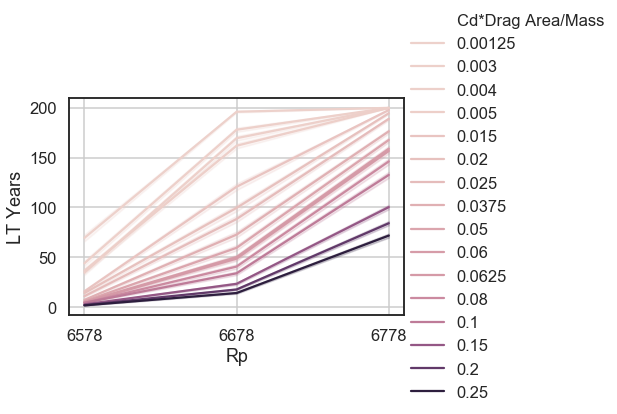

In [8]:
sns.lineplot("Rp", "LT Years", hue="Cd*Drag Area/Mass", legend="full", data=dfRes)
plt.xticks(np.arange(6578, 6878, 100))
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0, frameon=False);

### Compare Flux Sigma Level to Lifetime Predictions


In [9]:
# Compare the effects of flux sigma level
dfRes.groupby(["Rp", "Flux Sigma Level"]).describe()["LT Years"]

count        mean        std       min        25%  \
Rp     Flux Sigma Level                                                        
6578.0 -2.0              10944.0   14.585526  36.931330  0.164172   0.488223   
        0.0              10944.0   14.112141  35.624584  0.164107   0.488694   
        2.0              10944.0   13.737069  35.156345  0.164033   0.488718   
6678.0 -2.0              10944.0   79.280469  77.655298  0.530943  12.970468   
        0.0              10944.0   74.736152  76.256034  0.530765  12.411927   
        2.0              10944.0   71.764020  75.525502  0.518333  11.611831   
6778.0 -2.0              10944.0  154.974147  65.118493  8.270082  97.391395   
        0.0              10944.0  149.563814  67.134305  6.725625  86.182317   
        2.0              10944.0  142.718932  69.807251  6.237632  72.686516   

                                50%         75%    max  
Rp     Flux Sigma Level                                 
6578.0 -2.0                2.116440    7.906431  200.0  
        0.0                2.121742    7.480164  200.0  
        2.0                2.113662    6.929163  200.0  
6678.0 -2.0               41.382472  174.273540  200.0  
        0.0               36.745060  147.419733  200.0  
        2.0               33.002664  134.026185  200.0  
6778.0 -2.0              200.000000  200.000000  200.0  
        0.0              200.000000  200.000000  200.0  
        2.0              200.000000  200.000000  200.0

The flux sigma level doesn't appear to have a large affect on GTOs which already have lower lifetimes, but it does appear to cause a wider variability in GTOs with longer lifetimes. This effect can be seen looking at Rp = 6678 at the 75% level and Rp = 6778 at the 25% level.

### Compare Inclination to Lifetime Predictions

In [10]:
# Compare the effects of inclination
dfRes.groupby(["Rp", "i"]).describe()["LT Years"]

count        mean        std       min        25%         50%  \
Rp     i                                                                       
6578.0 0.0   10944.0   11.581613  29.533347  0.180319   0.457718    2.105618   
       15.0  10944.0   16.024319  39.207378  0.164033   0.492069    2.276413   
       30.0  10944.0   14.828803  38.070408  0.164972   0.556578    2.032133   
6678.0 0.0   10944.0   68.126788  74.207476  0.547873  10.455664   29.456985   
       15.0  10944.0   77.607564  77.320221  0.625886  13.105844   39.334120   
       30.0  10944.0   80.046290  77.547514  0.518333  13.592183   42.038416   
6778.0 0.0   10944.0  141.894736  70.853628  8.270082  67.506939  200.000000   
       15.0  10944.0  150.965454  66.364986  8.646362  89.079049  200.000000   
       30.0  10944.0  154.396703  64.714177  6.237632  98.676783  200.000000   

                    75%    max  
Rp     i                        
6578.0 0.0     7.302994  200.0  
       15.0    8.824354  200.0  
       30.0    6.220999  200.0  
6678.0 0.0   117.644232  200.0  
       15.0  168.809792  200.0  
       30.0  176.071851  200.0  
6778.0 0.0   200.000000  200.0  
       15.0  200.000000  200.0  
       30.0  200.000000  200.0

The lower inclinations tend to have a shorter lifetimes. But since launch site largely determines inclination this is usually not a design parameter.

### Compare Periapsis Location w.r.t. Sun and Moon to Lifetime Predictions

In [11]:
# limit the orbits to a subset of the data
rpVal = 6678
iVal = 30
maxCdDragAreaMassVal = 0.08

In [12]:
# Get Sun and Moon angle at epoch
try:
    app = GetActiveObject("STK11.Application")
    root = app.Personality2
except:
    app = CreateObject("STK11.Application")
    app.Visible = True
    app.UserControl = True
    root = app.Personality2
    root.Isolate()
    root.NewScenario("MoonAngle")
    scenario = root.CurrentScenario
    scenario2 = scenario.QueryInterface(STKObjects.IAgScenario)
    scenario2.StartTime = "10 Sep 2019 04:00:00.000"
    scenario2.StopTime = "11 Sep 2019 04:00:00.000"

# Create Longitude of Periapsis
dfRes["LoP"] = dfRes["RAAN"] + dfRes["AoP"]
dfRes.loc[dfRes["LoP"] >= 360, "LoP"] = dfRes.loc[dfRes["LoP"] >= 360, "LoP"] - 360
dfRes.loc[dfRes["LoP"] >= 360, "LoP"] = dfRes.loc[dfRes["LoP"] >= 360, "LoP"] - 360

try:
    moonRAAN = root.CentralBodies.Earth.Vgt.Angles.Item("MoonRAAN")
except:
    moonRAAN = root.CentralBodies.Earth.Vgt.Angles.Factory.Create(
        "MoonRAAN", "Moon RAAN", AgSTKVgtLib.eCrdnAngleTypeDihedralAngle
    )
moonRAAN2 = moonRAAN.QueryInterface(AgSTKVgtLib.IAgCrdnAngleDihedral)
moonRAAN2.FromVector.SetPath("CentralBody/Earth ICRF-X")
moonRAAN2.ToVector.SetPath("CentralBody/Earth Moon")
moonRAAN2.PoleAbout.SetPath("CentralBody/Moon Orbit_Normal")
root.UnitPreferences.SetCurrentUnit("DateFormat", "YYDDD")

dfRes["AngToMoon"] = dfRes["LoP"]
for uniqueEpoch in dfRes["epoch"].unique():
    indexs = np.round(dfRes["epoch"]) == np.round(uniqueEpoch)
    ang = moonRAAN.FindAngle(str(uniqueEpoch))
    dfRes.loc[indexs, "AngToMoon"] = (ang.Angle - dfRes.loc[indexs, "LoP"]).astype(
        float
    )
dfRes.loc[dfRes["AngToMoon"] < 0, "AngToMoon"] = dfRes["AngToMoon"] + 360

try:
    sunRAAN = root.CentralBodies.Earth.Vgt.Angles.Item("SunRAAN")
except:
    sunRAAN = root.CentralBodies.Earth.Vgt.Angles.Factory.Create(
        "SunRAAN", "sun RAAN", AgSTKVgtLib.eCrdnAngleTypeDihedralAngle
    )
sunRAAN2 = sunRAAN.QueryInterface(AgSTKVgtLib.IAgCrdnAngleDihedral)
sunRAAN2.FromVector.SetPath("CentralBody/Earth ICRF-X")
sunRAAN2.ToVector.SetPath("CentralBody/Earth Sun")
sunRAAN2.PoleAbout.SetPath("CentralBody/Earth Orbit_Normal")
root.UnitPreferences.SetCurrentUnit("DateFormat", "YYDDD")
dfRes["AngToSun"] = dfRes["LoP"]
for uniqueEpoch in dfRes["epoch"].unique():
    indexs = np.round(dfRes["epoch"]) == np.round(uniqueEpoch)
    ang = sunRAAN.FindAngle(str(uniqueEpoch))
    dfRes.loc[indexs, "AngToSun"] = (ang.Angle - dfRes.loc[indexs, "LoP"]).astype(float)
dfRes.loc[dfRes["AngToSun"] < 0, "AngToSun"] = dfRes["AngToSun"] + 360

At Epoch 19360

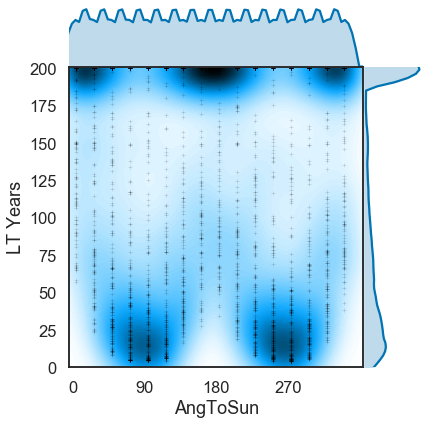

In [13]:
epochVal = 19360
data = dfRes[
    (dfRes["Rp"] == rpVal)
    & (dfRes["Cd*Drag Area/Mass"] <= maxCdDragAreaMassVal)
    & (dfRes["i"] == iVal)
    & (np.round(dfRes["epoch"]) == np.round(epochVal))
]
ax = sns.jointplot(
    data["AngToSun"],
    data["LT Years"],
    kind="kde",
    space=0,
    n_levels=100,
    height=6,
    kernel="epa",
    bw="silverman",
    marginal_kws={"kernel": "epa", "bw": "silverman"},
)
ax.plot_joint(plt.scatter, c="k", s=20, linewidth=0.5, marker="+", alpha=0.2)
plt.xticks(np.arange(0, 360, 90))
ax.ax_joint.set_xlim([-5, 365])
ax.ax_joint.set_ylim([0, 201]);

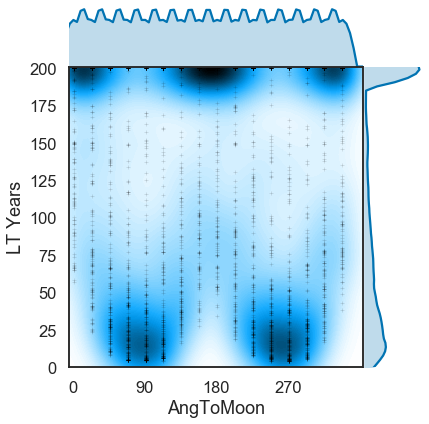

In [14]:
ax = sns.jointplot(
    data["AngToMoon"],
    data["LT Years"],
    kind="kde",
    space=0,
    n_levels=100,
    height=6,
    kernel="epa",
    bw="silverman",
    marginal_kws={"kernel": "epa", "bw": "silverman"},
)
ax.plot_joint(plt.scatter, c="k", s=20, linewidth=0.5, marker="+", alpha=0.2)
plt.xticks(np.arange(0, 360, 90))
ax.ax_joint.set_xlim([-5, 365])
ax.ax_joint.set_ylim([0, 201]);

At Epoch 19253.166667

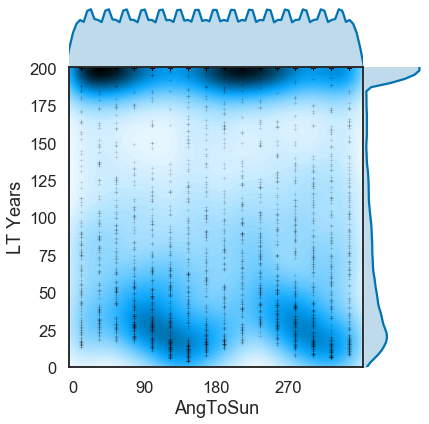

In [15]:
epochVal = 19253.166667
data = dfRes[
    (dfRes["Rp"] == rpVal)
    & (dfRes["Cd*Drag Area/Mass"] <= maxCdDragAreaMassVal)
    & (dfRes["i"] == iVal)
    & (np.round(dfRes["epoch"]) == np.round(epochVal))
]
ax = sns.jointplot(
    data["AngToSun"],
    data["LT Years"],
    kind="kde",
    space=0,
    n_levels=100,
    height=6,
    kernel="epa",
    bw="silverman",
    marginal_kws={"kernel": "epa", "bw": "silverman"},
)
ax.plot_joint(plt.scatter, c="k", s=20, linewidth=0.5, marker="+", alpha=0.2)
plt.xticks(np.arange(0, 360, 90))
ax.ax_joint.set_xlim([-5, 365])
ax.ax_joint.set_ylim([0, 201]);

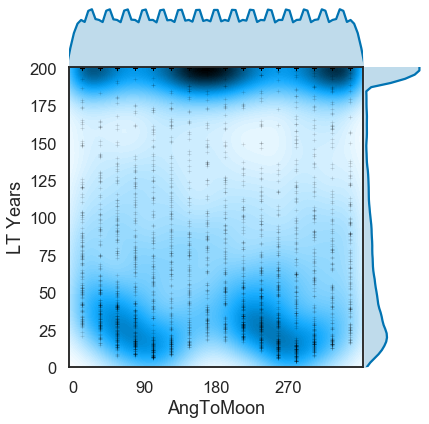

In [16]:
ax = sns.jointplot(
    data["AngToMoon"],
    data["LT Years"],
    kind="kde",
    space=0,
    n_levels=100,
    height=6,
    kernel="epa",
    bw="silverman",
    marginal_kws={"kernel": "epa", "bw": "silverman"},
)
ax.plot_joint(plt.scatter, c="k", s=20, linewidth=0.5, marker="+", alpha=0.2)
plt.xticks(np.arange(0, 360, 90))
ax.ax_joint.set_xlim([-5, 365])
ax.ax_joint.set_ylim([0, 201]);

There is clustering of orbit lifetimes based on the angle between periapsis and Sun/Moon. The angle is defined as the angle between the longitude of periapsis and the Sun/Moon position about their respective orbit normals. (This is not quite the same as the angle between periapsis and the Sun/Moon but it is quicker to calculate and similar). The angle is 0 when the celestial body is in line with the initial periapsis and +180 would indicate the celestial body is rotated in the plane of motion to align with apoapsis. Looking at different inclinations also affects the clustering. Detailed conclusions are not drawn here, but the orientation of the orbit w.r.t. the Moon and Sun has a substantial impact on the orbit lifetime.

### Look at Cd * Drag Area/Mass vs Mean Lifetime 

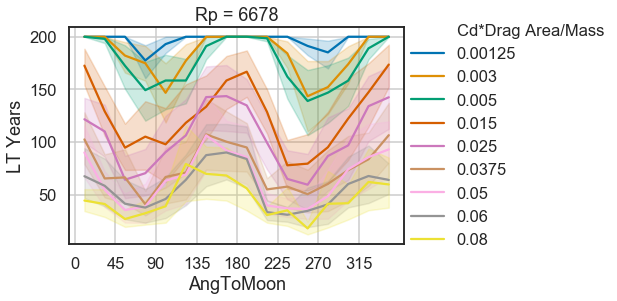

In [17]:
data = data[
    (data["Cd*Drag Area/Mass"] != 0.004)
    & (data["Cd*Drag Area/Mass"] != 0.02)
    & (data["Cd*Drag Area/Mass"] != 0.0625)
]  # limit lines drawn
numOfColors = len(data["Cd*Drag Area/Mass"].unique())
sns.lineplot(
    "AngToMoon",
    "LT Years",
    hue="Cd*Drag Area/Mass",
    legend="full",
    palette=sns.color_palette("colorblind")[0:numOfColors],
    data=data,
)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0, frameon=False)
plt.xticks(np.arange(0, 360, 45))
plt.grid(True)
plt.title("Rp = " + str(rpVal));

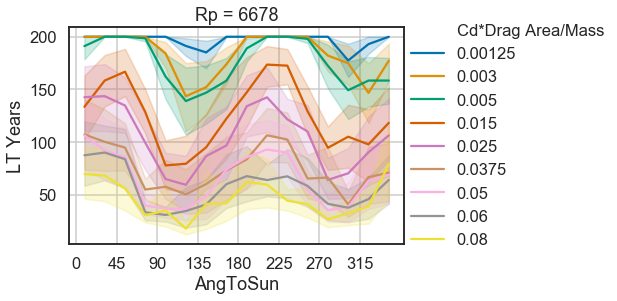

In [18]:
sns.lineplot(
    "AngToSun",
    "LT Years",
    hue="Cd*Drag Area/Mass",
    legend="full",
    palette=sns.color_palette("colorblind")[0:numOfColors],
    data=data,
)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0, frameon=False)
plt.xticks(np.arange(0, 360, 45))
plt.grid(True)
plt.title("Rp = " + str(rpVal));

The angles to the Sun/Moon have an impact on orbit lifetime which affect all satellites, but the specific Cd * Drag Area/Mass ratio for a given satellite also has a substantial impact.

In [19]:
# Load satellites into STK
dfLoad = data[data["LT Years"] < 25].sample(
    10
)  # load 10 satellite with lifetimes < 25 years
loadSats(dfLoad, maxSats=50, maxDur=tradeStudy.maxDur)

# How does the Lifetime Tool compare to HPOP for GTOs?

###  Look at the data set

An example GTO mission with different flux sigma levels, density models and also running HPOP. The radius of periapsis is 6577 km.

In [20]:
# Load trade study
tradeStudy = loadTradeStudy("LifeTimeGTOMissionVariations")
tradeStudy.properties()

{'fileName': 'LifeTimeGTOMissionVariations.csv',
 'numCores': 3,
 'runHPOP': True,
 'maxDur': 100,
 'decayAlt': 65,
 'epoch': 20073.33333333,
 'a': 24217,
 'e': 0.7284,
 'i': 26.5,
 'AoP': 180,
 'RAAN': 298.2,
 'TA': 17.3,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 0.18,
 'SunArea': 0.18,
 'Mass': 9,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 1,
 'GaussQuad': 8,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'GridSearch',
 'numberOfRuns': 30,
 'varyCols': ['Flux Sigma Level', 'Density Model'],
 'varyValues': [array([-2, -1,  0,  1,  2]),
  array(['Jacchia 1970', 'Jacchia 1971', 'Jacchia-Roberts', 'NRLMSISE 2000',
         'MSISE 1990', 'MSIS 1986'], dtype='<U15')],
 'setSunAreaEqualToDragArea': True}

In [21]:
# Load Data Frame
dfRes = readResults(tradeStudy)
dfRes["Runtime Ratio"] = dfRes["HPOP Runtime"] / dfRes["LT Runtime"]
dfRes["Years Signed Error"] = dfRes["LT Years"] - dfRes["HPOP Years"]
dfRes["Years Abs Error"] = abs(dfRes["LT Years"] - dfRes["HPOP Years"])
dfRes["Years % Error"] = (
    abs(dfRes["LT Years"] - dfRes["HPOP Years"]) / dfRes["HPOP Years"] * 100
)
dfRes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime,HPOP Years,HPOP Runtime,Runtime Ratio,Years Signed Error,Years Abs Error,Years % Error
count,30.000000,30.000000,30.0,3.000000e+01,30.0,3.000000e+01,30.0,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,30.0,30.00,30.00,30.0,3.000000e+01,3.000000e+01,30.0,30.0,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,0.00000,5534.833333,3.702185,1.400476,3.728545,84.735595,57.406901,-0.026359,0.090938,2.197698
std,8.803408,0.000000,0.0,3.387608e-16,0.0,5.781517e-14,0.0,7.226896e-15,9.250427e-13,2.960137e-11,9.250427e-12,0.000000,9.250427e-13,5.781517e-13,3.613448e-15,1.806724e-15,9.033621e-16,9.033621e-16,0.0,0.00,0.00,0.0,1.411503e-17,7.057516e-18,0.0,0.0,1.43839,307.003323,0.087429,0.547415,0.266497,59.819685,25.020026,0.209014,0.189343,3.801262
min,0.000000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,-2.00000,5293.000000,3.627204,0.594003,3.610139,33.464119,29.256154,-1.048201,0.003486,0.095507
25%,7.250000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,-1.00000,5372.250000,3.649348,0.791252,3.632299,37.491992,35.203088,-0.023808,0.015122,0.414397
50%,14.500000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,0.00000,5439.500000,3.668619,1.551985,3.653540,48.832707,49.278203,0.007257,0.043735,1.158247
75%,21.750000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,1.00000,5545.750000,3.719217,1.707514,3.692136,150.839765,84.380028,0.045847,0.087257,2.391089
max,29.000000,20073.333333,24217.0,7.284000e-01,26.5,2.982000e+02,180.0,1.730000e+01,6.577337e+03,4.185666e+04,1.136827e+04,-4597.838042,4.798715e+03,-8.896960e+02,-7.028652e+00,-5.766753e+00,-4.447078e+00,2.200000e+00,1.0,0.18,0.18,9.0,4.400000e-02,2.000000e-02,1.0,8.0,2.00000,6755.000000,4.017642,2.895043,5.065843,197.741890,104.251877,0.193980,1.048201,20.691547


### Compare Flux Sigma Level and Density Model to Lifetime Predictions

In [22]:
# Comparing HPOP and LT across Flux Sigma Levels
dfRes.groupby("Flux Sigma Level").describe()[["LT Years", "HPOP Years"]]

LT Years                                                    \
                    count      mean       std       min       25%       50%   
Flux Sigma Level                                                              
-2.0                  6.0  3.744782  0.066505  3.669924  3.694301  3.732966   
-1.0                  6.0  3.686405  0.038817  3.640675  3.656985  3.684620   
 0.0                  6.0  3.671086  0.056298  3.627204  3.634878  3.655460   
 1.0                  6.0  3.685749  0.096880  3.633918  3.638935  3.651082   
 2.0                  6.0  3.722904  0.146197  3.646188  3.649348  3.658547   

                                     HPOP Years                                \
                       75%       max      count      mean       std       min   
Flux Sigma Level                                                                
-2.0              3.798017  3.831724        6.0  3.643401  0.025293  3.610139   
-1.0              3.718939  3.730363        6.0  3.667891  0.071603  3.616970   
 0.0              3.675778  3.777824        6.0  3.686679  0.117498  3.618713   
 1.0              3.658656  3.882346        6.0  3.716810  0.110698  3.637192   
 2.0              3.697300  4.017642        6.0  3.927942  0.563028  3.649673   

                                                          
                       25%       50%       75%       max  
Flux Sigma Level                                          
-2.0              3.626927  3.644842  3.655105  3.681101  
-1.0              3.625563  3.639994  3.672460  3.806356  
 0.0              3.625388  3.628573  3.683301  3.918349  
 1.0              3.649850  3.675372  3.724683  3.930460  
 2.0              3.657602  3.669526  3.811972  5.065843

It looks like the orbit lifetime predictions vary +- 0.1 years from changing the flux sigma level. Interestingly the lifetime of the GTOs sometimes goes up with atmospheric flux. This would need to be investigated further to draw any conclusive results.

In [23]:
# Comparing HPOP and LT Across Density Models
dfRes.groupby("Density Model").describe()[["LT Years", "HPOP Years"]]

LT Years                                                    \
                   count      mean       std       min       25%       50%   
Density Model                                                                
Jacchia 1970         5.0  3.811695  0.140395  3.669924  3.710741  3.777824   
Jacchia 1971         5.0  3.667057  0.030282  3.637731  3.640675  3.661135   
Jacchia-Roberts      5.0  3.668406  0.050639  3.627204  3.634931  3.658499   
MSIS 1986            5.0  3.707172  0.077240  3.646188  3.650944  3.676641   
MSISE 1990           5.0  3.701589  0.068608  3.649204  3.651219  3.673189   
NRLMSISE 2000        5.0  3.657192  0.032118  3.633918  3.633927  3.649780   

                                    HPOP Years                                \
                      75%       max      count      mean       std       min   
Density Model                                                                  
Jacchia 1970     3.882346  4.017642        5.0  4.074590  0.565321  3.651941   
Jacchia 1971     3.688451  3.707295        5.0  3.635289  0.024699  3.610139   
Jacchia-Roberts  3.667315  3.754079        5.0  3.668135  0.029881  3.618713   
MSIS 1986        3.730363  3.831724        5.0  3.671556  0.043947  3.635349   
MSISE 1990       3.721671  3.812663        5.0  3.647359  0.013262  3.625230   
NRLMSISE 2000    3.656481  3.711853        5.0  3.674339  0.103034  3.616970   

                                                         
                      25%       50%       75%       max  
Density Model                                            
Jacchia 1970     3.806356  3.918349  3.930460  5.065843  
Jacchia 1971     3.622301  3.631283  3.637192  3.675529  
Jacchia-Roberts  3.663523  3.681101  3.681733  3.695603  
MSIS 1986        3.637744  3.649673  3.700640  3.734377  
MSISE 1990       3.644639  3.655140  3.655629  3.656160  
NRLMSISE 2000    3.623321  3.625862  3.648086  3.857453

It looks like the orbit lifetime predictions vary +- 0.1 years between different atmospheric density models. Although there is one outlier from an HPOP run at Flux Sigma Level = 2 using the Jacchia 1970 atmospheric density model.

### Compare Lifetime Predictions to HPOP

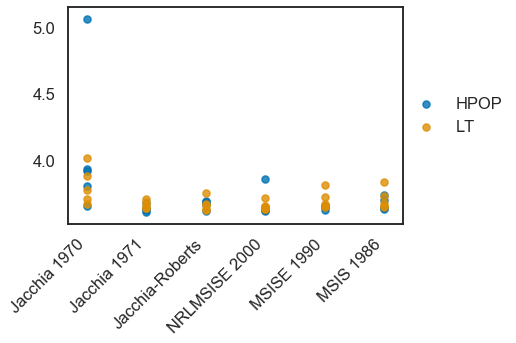

In [24]:
# Look at LT vs HPOP Predictions
dfSub = dfRes  # [dfRes['Flux Sigma Level'] == 0]
# plt.figure(figsize=(10,5))
plt.scatter(dfSub["Density Model"], dfSub["HPOP Years"], label="HPOP", s=50, alpha=0.8)
plt.scatter(dfSub["Density Model"], dfSub["LT Years"], label="LT", s=50, alpha=0.8)
plt.xticks(rotation=45, horizontalalignment="right")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0, frameon=False);

In [25]:
# Look at erorrs
dfRes.describe()[["Years Signed Error", "Years Abs Error", "Years % Error"]]

,Years Signed Error,Years Abs Error,Years % Error
count,30.000000,30.000000,30.000000
mean,-0.026359,0.090938,2.197698
std,0.209014,0.189343,3.801262
min,-1.048201,0.003486,0.095507
25%,-0.023808,0.015122,0.414397
50%,0.007257,0.043735,1.158247
75%,0.045847,0.087257,2.391089
max,0.193980,1.048201,20.691547


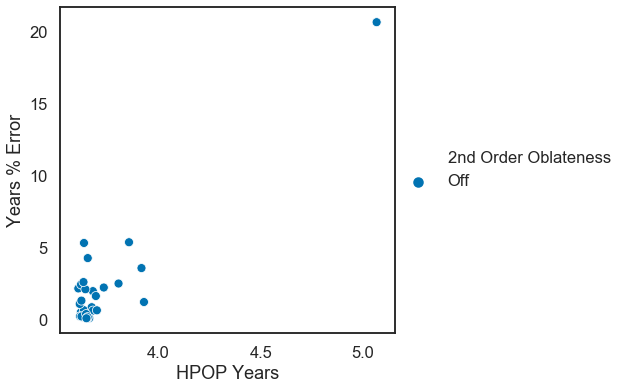

In [26]:
# Plot % error
plt.figure(figsize=(6, 6))
sns.scatterplot("HPOP Years", "Years % Error", hue="2nd Order Oblateness", data=dfRes)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), borderaxespad=0, frameon=False);

The lifetime tool gives similar results to HPOP within a few % for this GTO which has a low lifetime of 3.7 years. A few other GTOs were looked at and yielded similar results, although HPOP did tend to show a bit more variability in the orbit lifetimes  predictions with occasional outliers. Indicating that the lifetime tool is a good first guess but some of the other perturbations captured with HPOP may cause the orbit lifetime to have a wider distribution of outcomes. 